In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.linear_model as skl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import sys
sys.path.insert(0,"../src_rewrite/")

from FrankeFunction import FrankeFunction
from linear_regression import *
from bootstrap import *
from cross_validation import *
from stat_tools import *
from main import *
import utils
import unit_tests

utils.plot_settings()

FIGPATH = "../figs/"

In [2]:
# Make sure things are working as expected
unit_tests.OLS_unit_test()
unit_tests.OLS_SVD_unit_test()
unit_tests.Ridge_unit_test()

## Part a): Ordinary Least Square (OLS) on the Franke function 

- Play around with the franke funtion both with & without noise!
- Perform OLS up to 5th order
- Compute R2
- Compute MSE
- Find confidence interval of beta

In [3]:
# Generate test data
n = 500 # Number of data points

x_dat = np.random.uniform(0, 1, n)
y_dat = np.random.uniform(0, 1, n)
z_dat = FrankeFunction(x_dat, y_dat)

# Set up the scaler
scaler = StandardScaler()

print()

In [4]:
# Wrap the analysis in a function to duplicate for Clean & Noisy data
def p1_analysis(x, y, z, degrees):
    
    mse = pd.DataFrame(columns=["train", "test"], index = degrees)
    r2 = pd.DataFrame(columns=["train", "test"], index = degrees)
    
    # Very hacky way of determining the maximum number of terms of the polynomials
    betas = np.zeros([len(degrees), len(utils.polynomial_form(degrees[-1]))])
    var_betas = np.zeros([len(degrees), len(utils.polynomial_form(degrees[-1]))])

    #var_b = pd.DataFrame(indices=degrees)
    
    for i, deg in enumerate(degrees):
        X = design_matrix(x, y, deg)
        # Split data, but don't shuffle. OK since data is already randomly sampled! 
        # Fasilitates a direct comparrison of the clean & Noisy data
        X_train, X_test, z_train, z_test = train_test_split(X, z, test_size = 0.2, shuffle=False)
        # Normalize data sets
        X_train = scaler.fit_transform(X_train)
        X_train[:, 0] = np.ones(X_train.shape[0])
        X_test = scaler.fit_transform(X_test)
        X_test[:, 0] = np.ones(X_test.shape[0])

        beta = OLS_SVD(X_train, z_train)
    
        mse["train"][i] = MSE(z_train, X_train @ beta)
        mse["test"][i] = MSE(z_test, X_test @ beta)
        r2["train"][i] = R2(z_train, X_train @ beta)
        r2["test"][i] = R2(z_test, X_test @ beta)
        
        betas[i, 0:len(beta)] = beta
        var_betas[i, 0:len(beta)] = var_beta(X_train, z_train)

    return mse, r2, betas, var_betas

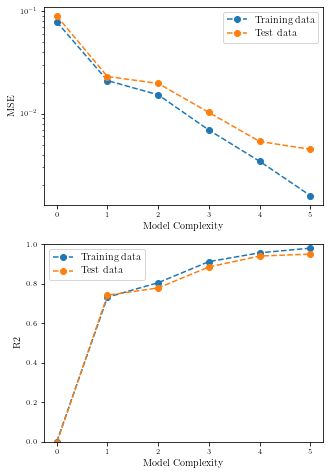

In [5]:
degrees = np.arange(0, 6) # Degrees of the polynom

# Generate data
MSE_clean, R2_clean, betas_clean, var_betas_clean = p1_analysis(x_dat, y_dat, z_dat, degrees)

plt.figure(figsize=(5,8))
plt.tight_layout()
# Plot MSE
plt.subplot(211)
plt.semilogy(degrees, MSE_clean["train"],"o--", label = "Training data")
plt.semilogy(degrees, MSE_clean["test"],"o--", label = "Test data")
plt.xlabel("Model Complexity")
plt.ylabel("MSE")
plt.legend()
# Plot R2
plt.subplot(212)
plt.plot(degrees, R2_clean["train"],"o--", label = "Training data")
plt.plot(degrees, R2_clean["test"],"o--", label = "Test data")
plt.xlabel("Model Complexity")
plt.ylabel("R2")
plt.ylim([0,1])
plt.legend()

<ipython-input-6-90dd0405103c>:2: RuntimeWarning: divide by zero encountered in log10
  plt.matshow((np.log10(2 * np.sqrt(var_betas_clean))))


<Figure size 1440x720 with 0 Axes>

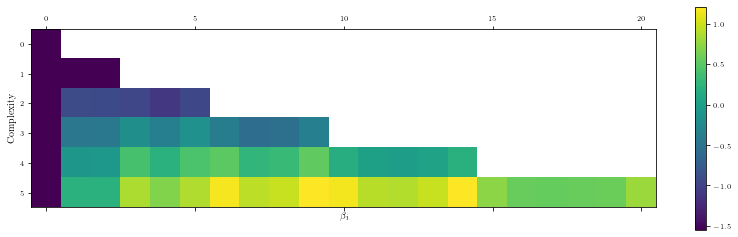

In [6]:
plt.figure(figsize=(20, 10))
plt.matshow((np.log10(2 * np.sqrt(var_betas_clean))))
plt.ylabel("Complexity")
plt.xlabel("$\\beta_i$")
plt.colorbar()
plt.savefig("test.pdf")

In [7]:
utils.polynomial_form(5)

['$\\beta_0$',
 '$\\beta_1 x^1 y^0$',
 '$\\beta_2 x^0 y^1$',
 '$\\beta_3 x^2 y^0$',
 '$\\beta_4 x^1 y^1$',
 '$\\beta_5 x^0 y^2$',
 '$\\beta_6 x^3 y^0$',
 '$\\beta_7 x^2 y^1$',
 '$\\beta_8 x^1 y^2$',
 '$\\beta_9 x^0 y^3$',
 '$\\beta_10 x^4 y^0$',
 '$\\beta_11 x^3 y^1$',
 '$\\beta_12 x^2 y^2$',
 '$\\beta_13 x^1 y^3$',
 '$\\beta_14 x^0 y^4$',
 '$\\beta_15 x^5 y^0$',
 '$\\beta_16 x^4 y^1$',
 '$\\beta_17 x^3 y^2$',
 '$\\beta_18 x^2 y^3$',
 '$\\beta_19 x^1 y^4$',
 '$\\beta_20 x^0 y^5$']

How does the model respond to noise?

[]

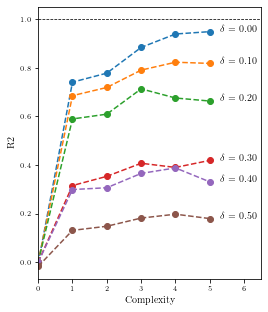

In [8]:
noises = np.linspace(0, .5, 6)
degrees = np.arange(0, 6)

plt.figure(figsize=[4, 5])

for noise in noises:
    # Generate a new noisy dataset
    z_dat_noisy = z_dat + np.random.normal(0, 1, n) * noise
    MSE_noisy, R2_noisy, _, _ = p1_analysis(x_dat, y_dat, z_dat_noisy,degrees)
    
    plt.plot(degrees, R2_noisy["test"], "o--")
    plt.annotate("$\delta=$ %.2f" % noise, [degrees[-1] + .3,R2_noisy["test"].iloc[-1]])

plt.xlim([0, degrees[-1] + 1.5])
plt.axhline([1],color="black", ls="--", lw=0.75)
plt.xlabel("Complexity")
plt.ylabel("R2")
plt.plot()

In [9]:
# Add noise to z_dat going forward.
z_dat *= np.random.normal(0, 1, n) * 0.2 

## Part b): Bias-variance trade-off and resamplng techniques 
- Replicate Fig 2.11 from Hastie et al using bootstrap
- Bias variance analysis

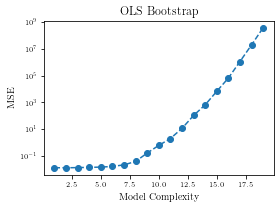

In [10]:
# Reproduce 2.11 in Hastie
degrees = np.arange(1, 20)
N_bootstraps = 300
OLS_BS_MSE, OLS_BS_BIAS2, OLS_BS_VAR = bootstrap_analysis(x_dat, y_dat, z_dat, degrees, N_bootstraps)

plt.figure(figsize=(4,3))
plt.semilogy(degrees, OLS_BS_MSE,"o--")
plt.xlabel("Model Complexity")
plt.ylabel("MSE")
plt.title("OLS Bootstrap")
plt.tight_layout()
plt.savefig(FIGPATH + "OLS_MSE_Bootstrap_Hastie_211.pdf")

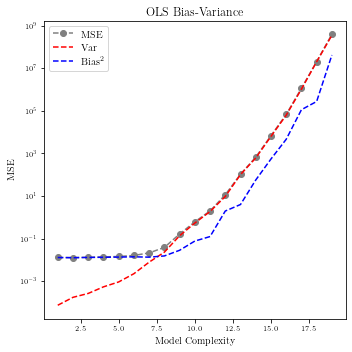

In [11]:
# Bias-Variance Figure

plt.figure(figsize=(5,5))
plt.semilogy(degrees, OLS_BS_MSE,"o--", label = "MSE", color="gray")
plt.semilogy(degrees, OLS_BS_VAR,"--", label = "Var", color="red")
plt.semilogy(degrees, OLS_BS_BIAS2 ,"--", label = "Bias$^2$", color="blue")
plt.xlabel("Model Complexity")
plt.ylabel("MSE")
plt.title("OLS Bias-Variance")
plt.legend(loc="best")
plt.tight_layout()

## Part c) Cross-validation as resampling techniques, adding more complexity 
- Do cross validation on the dataset. Compare MSE with bootstrap

In [12]:
degrees = np.arange(1, 20)
OLS_MSE_CV = cv_analysis(x_dat, y_dat, z_dat, degrees, k=5)

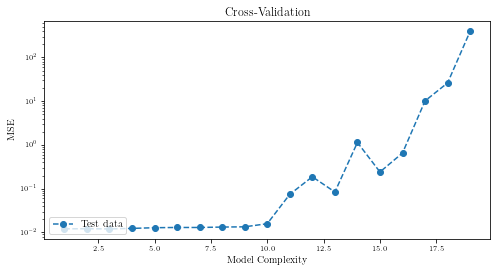

In [13]:
plt.figure(figsize=(8,4))
plt.semilogy(degrees, OLS_MSE_CV,"o--", label = "Test data")
plt.xlabel("Model Complexity")
plt.ylabel("MSE")
plt.title("Cross-Validation")
plt.legend(loc="lower left")

## Part d): Ridge Regression on the Franke function with resampling 
- Do same analysis, but with Ridge regression

In [14]:
lambdas = np.logspace(-3, 1, 20)
degrees = np.arange(1, 15)

Ridge_BS_MSE = np.empty((lambdas.size, degrees.size))
Ridge_BS_BIAS2 = np.empty((lambdas.size, degrees.size))
Ridge_BS_VAR = np.empty((lambdas.size, degrees.size))

Ridge_CV_MSE = np.empty((lambdas.size, degrees.size))

for i in range(lambdas.size):    
    N_bootstraps = 50
    # Compute CV
    Ridge_CV_MSE[i, :] = cv_analysis(x_dat, y_dat, z_dat, degrees, k=5, regression= lambda X, z : linear_regression.Ridge(X, z, lamb = lambdas[i]))    
    # Compute MSE
    Ridge_BS_MSE[i, :], Ridge_BS_BIAS2[i, :], Ridge_BS_VAR[i, :] = bootstrap_analysis(x_dat, y_dat, z_dat, degrees, N_bootstraps, 
                                                                                      regression = lambda X, z : linear_regression.Ridge(X, z, lamb = lambdas[i]))


Text(0.5, 1.0, 'Ridge $k=5$ fold cross validation')

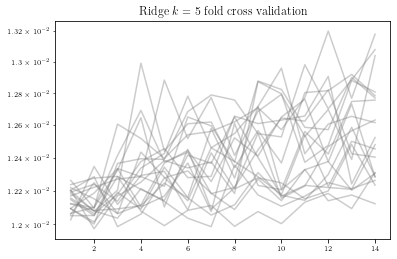

In [15]:
for i in range(lambdas.size):
    plt.semilogy(degrees, Ridge_CV_MSE[i, :], alpha = 0.4, color="gray")
    
plt.title("Ridge $k=5$ fold cross validation")

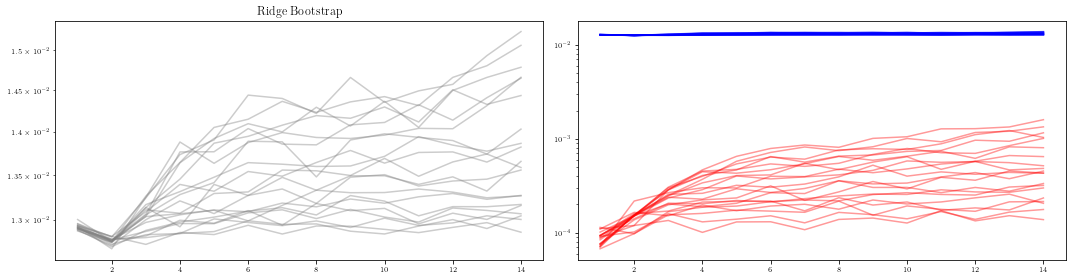

In [16]:
plt.figure(figsize=(15, 4))

plt.subplot(121)
for i in range(lambdas.size):
    plt.semilogy(degrees, Ridge_BS_MSE[i, :], alpha=0.4, color="gray")
plt.title("Ridge Bootstrap")
    
plt.subplot(122)
for i in range(lambdas.size):
    plt.semilogy(degrees, Ridge_BS_VAR[i, :], alpha=0.4, color="red")
    plt.semilogy(degrees, Ridge_BS_BIAS2[i, :], alpha=0.4, color="blue")

    
plt.tight_layout()

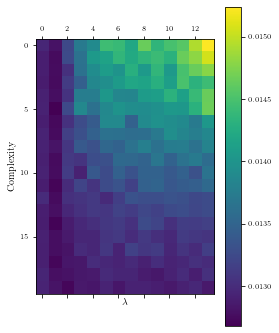

In [17]:
plt.matshow(Ridge_BS_MSE)
plt.xlabel("$\\lambda$")
plt.ylabel("Complexity")
plt.colorbar()

## Part e): Lasso Regression on the Franke function with resampling 
- Do Same analysis, but with Lasso Regression

In [18]:
lambdas = np.logspace(-3, 0, 20)
degrees = np.arange(1, 15)

LASSO_BS_MSE = np.empty((lambdas.size, degrees.size))
LASSO_BS_BIAS2 = np.empty((lambdas.size, degrees.size))
LASSO_BS_VAR = np.empty((lambdas.size, degrees.size))
LASSO_CV_MSE = np.empty((lambdas.size, degrees.size))

for i in range(lambdas.size):    
    N_bootstraps = 50
    LASSO_CV_MSE[i, :] = cv_analysis(x_dat, y_dat, z_dat, degrees, k=5, regression = "LASSO", lambd = lambdas[i])  
    LASSO_BS_MSE[i, :], LASSO_BS_BIAS2[i, :], LASSO_BS_VAR[i, :] = bootstrap_analysis(x_dat, y_dat, z_dat, degrees, N_bootstraps, 
                                                                                      regression = "LASSO", lambd=lambdas[i])

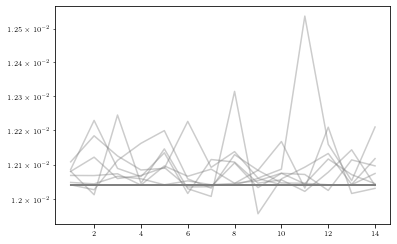

In [19]:
for i in range(lambdas.size):
    plt.semilogy(degrees, LASSO_CV_MSE[i, :], alpha = 0.4, color="gray")

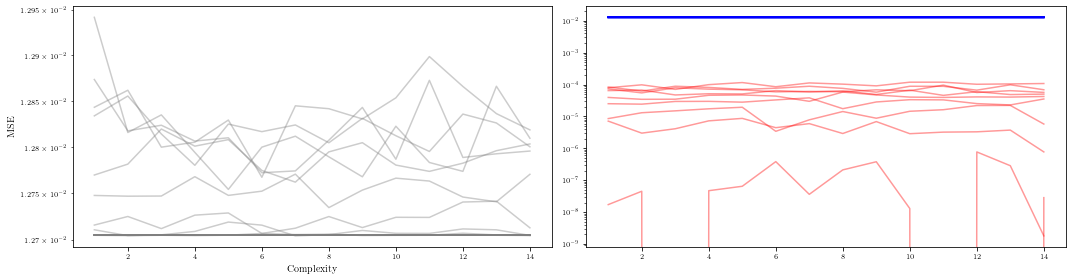

In [20]:
plt.figure(figsize=(15, 4))

plt.subplot(121)
for i in range(lambdas.size):
    plt.semilogy(degrees, LASSO_BS_MSE[i, :], alpha=0.4, color="gray")
    
plt.xlabel("Complexity")
plt.ylabel("MSE")
    
plt.subplot(122)
for i in range(lambdas.size):
    plt.semilogy(degrees, LASSO_BS_VAR[i, :], alpha=0.4, color="red")
    plt.semilogy(degrees, LASSO_BS_BIAS2[i, :], alpha=0.4, color="blue")
    
    
plt.tight_layout()

# Problem 1f)
- Download real data!

# Problem 1d)
= Analyse real data using wisdom gained from Franke Function!

In [21]:
def k_fold_split(X, z, k_folds = 5):
    perm = np.random.permutation(len(z))
    perm = np.split(perm, k_folds)
    return perm

X =  np.ones([5, 5])
z = np.ones([5])
for i in range(5):
    X[i] *= i
    z[i] *= i